# <center> Report_01</center>
# <center> Accident Claims(交通事故理赔审核预测)</center>
* 姓名:陈蜀
* 学号:2018300478
【注】本报告中包含的内容分布于文件夹report_01_accident_claims中的`accident claims_comparison_陈蜀.py`、`accident claims_kmeans_陈蜀.py`、`accident claims_logisticregression_陈蜀.py`、`accident claims_randomforest_陈蜀.py`  
生成的数据包括：`my_RF_prediction_logisticregression.csv`、`my_RF_prediction_randomforest.csv`、`submit_data_kmeans.csv`、`submit_data_logisticregression.csv`、`submit_data_randomforest.csv`

## 一、任务介绍
1. 任务类型：二元分类
2. 背景介绍：在交通摩擦（事故）发生后，理赔员会前往现场勘察、采集信息，这些信息往往影响着车主是否能够得到保险公司的理赔。
3. 数据：  

|文件名|文件内容| 数据数量 |
| :----: | :----: | :----: |
| train.csv | 训练数据集 | 200000条样本 |
| test.csv | 预测数据集 | 80000条样本 |
| sample_submit.csv | 提交示例 ||

4. 数据中变量名的解释

|变量名|解释|
| :----: | :----: |
| CaseId | 案例编号，没有实际意义 |
| Q1 | 理赔员现场勘察采集的信息，Q1代表第一个问题的信息。信息被编码成数字，数字的大小不代表真实的关系 | 
| Qk | 同上，Qk代表第k个问题的信息。一共36个问题|
| Evaluation | 表示最终审核结果。0表示授予理赔，1表示未通过理赔审核。在test.csv中，这是需要被预测的标签 |

5. 最终目标：根据这36条信息预测该事故方没有被理赔的概率。
6. 评价方法：Precision-Recall AUC  
 * 提交结果为每个测试样本未通过审核的概率，也就是Evaluation为1的概率。评价方法为精度-召回曲线下面积(Precision-Recall AUC)，以下简称PR-AUC。  
 * PR-AUC的取值范围是0到1。越接近1，说明模型预测的结果越接近真实结果。


## 二、解题思路及代码实现
### 了解数据
~head()：默认显示前5行数据，可指定显示多行，例如.head(15)显示前15行。  
显示5行就足够了，只需要看一下表头和大致的数据类型。


In [4]:
#导入需用库
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

#读取数据
homePath = "data"
trainPath = os.path.join(homePath, "train.csv")
testPath = os.path.join(homePath, "test.csv")
submitPath = os.path.join(homePath, "sample_submit.csv")
trainData = pd.read_csv(trainPath)
testData = pd.read_csv(testPath)
submitData = pd.read_csv(submitPath)

#显示数据，便于了解数据内容
trainData.head()

CaseId  Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  ...  Q28  Q29  Q30  Q31  Q32  \
0       1   0   0   0   0   0   0   0   0   0  ...    0    0    0    0    0   
1       2   0   0   0   0   0   0   0   0   0  ...    0    1    1    1    1   
2       3   0   0   0   0   0   0   0   1   0  ...    1    2    2    2    1   
3       4   0   0   0   0   0   0   0   0   0  ...    1    3    2    3    1   
4       5   0   0   0   0   0   0   0   0   0  ...    1    4    2    4    1   

   Q33  Q34  Q35  Q36  Evaluation  
0    0    0    0    0           0  
1    0    0    0    0           0  
2    0    0    0    0           0  
3    0    0    1    1           0  
4    0    0    1    1           0  

[5 rows x 38 columns]

`train.csv`文件中的数据包括CaseId、Q1~Q36、Evaluation。其中CaseId没有实际意义，在数据处理时应去掉。在对数据进行训练时，也不需要Evaluation这一栏数据，故去掉。组后分析模型准确性时，需要对比训练数据集预测出的Evaluation和实际真实的Evaluation，因此，后面需要将Evaluation这一栏数据单独读出。

In [5]:
testData.head()

CaseId  Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  ...  Q27  Q28  Q29  Q30  Q31  \
0  200001   0   0   0   0   0   0   4   0   0  ...    0    0    2    1   12   
1  200002   0   0   0   0   0   0   0   0   0  ...    0    2    5    0    8   
2  200003   0   0   0   0   0   0   0   0   0  ...    0    0    3    1    3   
3  200004   0   0   0   0   0   0   0   0   0  ...    0    1    3    1    1   
4  200005   0   0   0   0   0   0   0   0   2  ...    0    1    6    1   13   

   Q32  Q33  Q34  Q35  Q36  
0    1    0    0    0    0  
1    1    0    0    1    1  
2    1    0    0    1    1  
3    1    0    0    1    1  
4    1    0    0    1    1  

[5 rows x 37 columns]

`test.csv`文件中的数据包括CaseId、Q1~Q36。同上，其中CaseId没有实际意义，在数据处理时应去掉。

### （一）采用Logistic Regression进行二分类
对应的py文件：`accident claims_logisticregression_陈蜀.py`
#### · 解题思路：  
  1. 读取并处理数据；  
  2. 用Logistic Regression等预测模型对数据集进行训练、预测；  
  3. 绘制PR曲线、ROC曲线；计算预测准确率、AUC值；  
  4. 通过观察曲线变化趋势，对比预测准确率和AUC等值，评价预测模型的优劣。  
  
（后续其他模型的解题思路和该思路大同小异，故后面不再赘述）


#### · 代码实现：

#### 1) 导入需用库

In [30]:
#导入需用库
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
#sklearn中相关库
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,precision_recall_curve,average_precision_score

#plot中显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#### 2) 读取数据
读取数据后，需要对数据进行处理，如：去掉读取数据中的CaseId和训练数据集中的Evaluation，便于后续对数据的处理。

In [31]:
#读取数据
train_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv") #训练数据集
test_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\test.csv") #测试数据集
#submit_dataset = pd.read_csv("submit_data.csv") #提交的数据

#原始数据的处理
train_dataset = train_dataset.drop(['CaseId','Evaluation'],axis=1) #去掉CaseId和Evaluation,得到Qk
test_dataset = test_dataset.drop(['CaseId'],axis=1)
evaluation_true = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv",usecols=['Evaluation']) #读取evaluation,后续可以转换为列表

#### 3) Logistic Regression
利用lr.predict()对Evaluation进行预测。  
利用lr.predict_proba()获得预测结果为1的概率。  
数据预测、处理完成后，对数据进行保存。测试数据的**预测结果**保存在`submit_data_logisticregression.csv`文件中，测试数据集预测**结果为1的概率**保存在`my_RF_prediction_logisticregression`中。

In [32]:
#Logistic Regression预测
lr = LogisticRegression()
lr.fit(train_dataset, evaluation_true)

pred_train = lr.predict(train_dataset) #训练数据的预测结果
pred_test = lr.predict(test_dataset) #测试数据的预测结果
pred_test_probability = lr.predict_proba(test_dataset)[:,1] #测试数据的预测结果为1的概率，即获得赔偿的概率。[:,0]是预测结果为0的概率

#预测后所得数据的处理
caseid = np.array(range(80000))+200001 #生成CaseId，方便后续和预测结果、结果概率等数据绑定后保存
caseid = pd.DataFrame(caseid,index=None,columns=['CaseId']) #把caseid由array转化为DataFrame
pred_test = pd.DataFrame(pred_test,index=None,columns=['Evaluation']) #把测试数据的预测结果由array转化为DataFrame
pred_test_probability = pd.DataFrame(pred_test_probability,index=None,columns=['probability for "1"']) #把测试数据的预测结果为1的概率由array转化为DataFrame
submit_data = pd.concat([caseid,pred_test],axis=1) #合并caseid和pred_test
probability = pd.concat([caseid,pred_test_probability],axis=1) #合并caseid和pred_test_probability

#保存数据
submit_data.to_csv("submit_data_logisticregression.csv", index=False)
probability.to_csv("my_RF_prediction_logisticregression.csv",index=False)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 4) 预测准确率的计算
通过对比训练数据集的预测结果和已知的Evaluation，得到预测的准确率为88.68%。

In [33]:
#预测准确率的计算
acc_train = accuracy_score(evaluation_true,pred_train)*100#准确率
ave_train = average_precision_score(evaluation_true,pred_train)#平均预测分数
print("训练数据的预测正确率 = %.2f" % acc_train,"%")

训练数据的预测正确率 = 88.68 %


#### 5) 混淆矩阵可视化

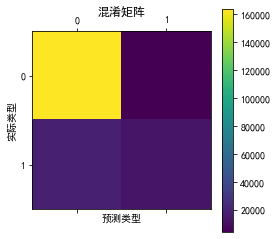

In [34]:
def confusion_metrix_show(evaluation_true,pred_train):
    Confusion_matrix=confusion_matrix(evaluation_true,pred_train) #evaluation_true真实值，pred_train预测值
    plt.matshow(Confusion_matrix)
    plt.title("混淆矩阵")
    plt.ylabel("实际类型")
    plt.xlabel("预测类型")
    plt.colorbar()
    plt.show()
confusion_metrix_show(evaluation_true,pred_train)

#### 6) 绘制PR曲线

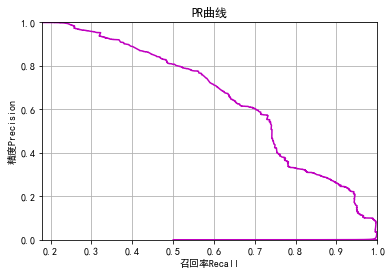

In [15]:
def pr_show(evaluation_true,train_dataset):
    #roc = roc_auc_score(evaluation_true,pred_train)
    y_pro = lr.predict_proba(train_dataset)[:,1]
    precision, recall, thresholds = precision_recall_curve(evaluation_true,y_pro)
    plt.figure()
    plt.plot(precision, recall,'m')
    plt.xlabel('召回率Recall')
    plt.ylabel('精度Precision')
    plt.grid(True)
    plt.xlim([0.18, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('PR曲线')
    plt.show()
pr_show(evaluation_true,train_dataset)

#### 7) 绘制ROC曲线并计算AUC
观察ROC曲线，且AUC的值为0.91，很接近1；结合前面计算的预测准确率，可知Logistic Regression的预测结果较准确，该分类器良好。

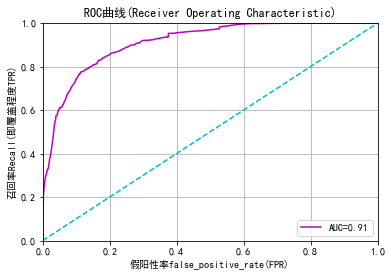

In [16]:
def ROC_show(evaluation_true,train_dataset):
    y_pro = lr.predict_proba(train_dataset)[:,1]
    false_positive_rate, recall, thresholds = roc_curve(evaluation_true,y_pro)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title("ROC曲线(Receiver Operating Characteristic)")#verticalalignment='center'→一个规定title格式的参数，个人觉得加上不好看
    plt.plot(false_positive_rate,recall,'m',label='AUC=%0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'c--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.grid(True)
    plt.ylabel('召回率Recall(即覆盖程度TPR)')
    plt.xlabel('假阳性率false_positive_rate(FPR)')
    plt.show()
ROC_show(evaluation_true,train_dataset)

### （二）采用K-Means进行二分类
对应的py文件：`accident claims_kmeans_陈蜀.py`

#### 1) 导入需用库

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
#sklearn中相关库
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#### 2) 读取数据
数据的读取和处理同Logistic Regression。

In [19]:
#读取数据
train_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv") #训练数据集
test_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\test.csv") #测试数据集
#submit_dataset = pd.read_csv("submit_data.csv") #提交的数据

#原始数据的处理
train_dataset = train_dataset.drop(['CaseId','Evaluation'],axis=1) #去掉CaseId和Evaluation,得到Qk
test_dataset = test_dataset.drop(['CaseId'],axis=1)
evaluation_true = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv",usecols=['Evaluation']) #读取evaluation,后续可以转换为列表

#### 3) K-Means
由于kmeans没有predict_proba，因此不计算预测概率等。
数据预测、处理完成后，对数据进行保存。测试数据的**预测结果**保存在`submit_data_kmeans.csv`文件中。

In [24]:
#K-Means预测
est = KMeans(n_clusters=2, init="k-means++", n_jobs=-1)
est.fit(train_dataset, evaluation_true)

pred_train = est.predict(train_dataset) #训练数据的预测结果
pred_test = est.predict(test_dataset) #测试数据的预测结果

#预测后所得数据的处理
caseid = np.array(range(80000))+200001 #生成CaseId，方便后续和预测结果、结果概率等数据绑定后保存
caseid = pd.DataFrame(caseid,index=None,columns=['CaseId']) #把caseid由array转化为DataFrame
pred_test = pd.DataFrame(pred_test,index=None,columns=['Evaluation']) #把测试数据的预测结果由array转化为DataFrame
submit_data = pd.concat([caseid,pred_test],axis=1) #合并caseid和pred_test

#保存数据
submit_data.to_csv("submit_data_kmeans.csv", index=False)

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


#### 4) 预测准确率的计算

In [25]:
#预测准确率的计算
acc_train = accuracy_score(evaluation_true,pred_train)*100#准确率
print("训练数据的预测正确率 = %.2f" % acc_train,"%")

训练数据的预测正确率 = 68.21 %


通过对比训练数据集的预测结果和已知的Evaluation，得到预测的准确率为68.21%，低于Logistic Regression。

#### 5) 混淆矩阵可视化

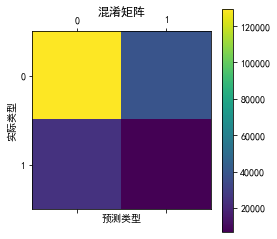

In [26]:
#混淆矩阵可视化
def confusion_metrix_show(evaluation_true,pred_train):
    Confusion_matrix=confusion_matrix(evaluation_true,pred_train) #evaluation_true真实值，pred_train预测值
    plt.matshow(Confusion_matrix)
    plt.title("混淆矩阵")
    plt.ylabel("实际类型")
    plt.xlabel("预测类型")
    plt.colorbar()
    plt.show()
confusion_metrix_show(evaluation_true,pred_train)

### （三）采用随机森林进行二分类
对应的py文件：`accident claims_randomforest_陈蜀.py`

#### 1) 导入需用库

In [27]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
#sklearn中相关库
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,precision_recall_curve,average_precision_score

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#### 2) 读取数据
数据的读取和处理同Logistic Regression和K-Means。

In [28]:
#读取数据
train_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv") #训练数据集
test_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\test.csv") #测试数据集

#原始数据的处理
train_dataset = train_dataset.drop(['CaseId','Evaluation'],axis=1) #去掉CaseId和Evaluation,得到Qk
test_dataset = test_dataset.drop(['CaseId'],axis=1)
evaluation_true = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv",usecols=['Evaluation']) #读取evaluation,后续可以转换为列表

#### 3) 随机森林
利用clf.predict()对Evaluation进行预测。  
利用clf.predict_proba()获得预测结果为1的概率。  
数据预测、处理完成后，对数据进行保存。测试数据的**预测结果**保存在`submit_data_randomforest.csv`文件中，测试数据集预测**结果为1的概率**保存在`my_RF_prediction_randomforest.csv`中。

In [35]:
#随机森林预测
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(train_dataset, evaluation_true)

pred_train = clf.predict(train_dataset) #训练数据的预测结果
pred_test = clf.predict(test_dataset) #测试数据的预测结果
pred_test_probability = clf.predict_proba(test_dataset)[:,1] #测试数据的预测结果为1的概率，即获得赔偿的概率。[:,0]是预测结果为0的概率

#预测后所得数据的处理
caseid = np.array(range(80000))+200001 #生成CaseId，方便后续和预测结果、结果概率等数据绑定后保存
caseid = pd.DataFrame(caseid,index=None,columns=['CaseId']) #把caseid由array转化为DataFrame
pred_test = pd.DataFrame(pred_test,index=None,columns=['Evaluation']) #把测试数据的预测结果由array转化为DataFrame
pred_test_probability = pd.DataFrame(pred_test_probability,index=None,columns=['probability for "1"']) #把测试数据的预测结果为1的概率由array转化为DataFrame
submit_data = pd.concat([caseid,pred_test],axis=1) #合并caseid和pred_test
probability = pd.concat([caseid,pred_test_probability],axis=1) #合并caseid和pred_test_probability

#保存数据
submit_data.to_csv("submit_data_randomforest.csv", index=False)
probability.to_csv("my_RF_prediction_randomforest.csv",index=False)

<ipython-input-35-116d81b4dbd2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_dataset, evaluation_true)


#### 4) 预测准确率的计算

In [36]:
#预测准确率的计算
acc_train = accuracy_score(evaluation_true,pred_train)*100#准确率
print("训练数据的预测正确率 = %.2f" % acc_train,"%")

训练数据的预测正确率 = 93.15 %


通过对比训练数据集的预测结果和已知的Evaluation，得到预测的准确率为93.15%，是三个模型预测结果中准确率最高的。

#### 5) 混淆矩阵可视化

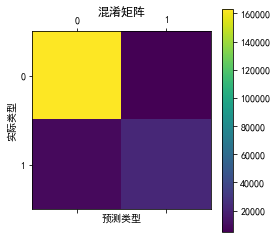

In [37]:
#混淆矩阵可视化
def confusion_metrix_show(evaluation_true,pred_train):
    Confusion_matrix=confusion_matrix(evaluation_true,pred_train) #evaluation_true真实值，pred_train预测值
    plt.matshow(Confusion_matrix)
    plt.title("混淆矩阵")
    plt.ylabel("实际类型")
    plt.xlabel("预测类型")
    plt.colorbar()
    plt.show()
confusion_metrix_show(evaluation_true,pred_train)

#### 6) 绘制PR曲线

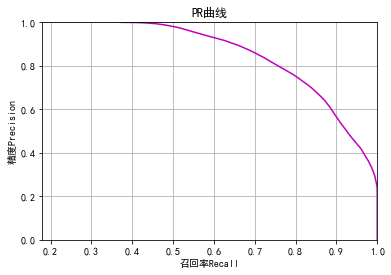

In [38]:
#绘制PR曲线
def pr_show(evaluation_true,train_dataset):
    #roc = roc_auc_score(evaluation_true,pred_train)
    y_pro = clf.predict_proba(train_dataset)[:,1]
    precision, recall, thresholds = precision_recall_curve(evaluation_true,y_pro)
    plt.figure()
    plt.plot(precision, recall,'m')
    plt.xlabel('召回率Recall')
    plt.ylabel('精度Precision')
    plt.grid(True)
    plt.xlim([0.18, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('PR曲线')
    plt.show()
pr_show(evaluation_true,train_dataset)

#### 7) 绘制ROC曲线并计算AUC
观察ROC曲线，且AUC的值为0.97，更加接近1；结合前面计算的预测准确率，可知随机森林的预测结果比Logistic Regression更准确，该分类器优良。

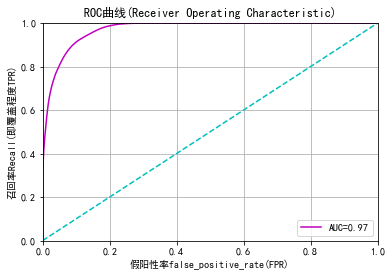

In [39]:
#绘制ROC曲线，用于判断模型好坏
def ROC_show(evaluation_true,train_dataset):
    y_pro = clf.predict_proba(train_dataset)[:,1]
    false_positive_rate, recall, thresholds = roc_curve(evaluation_true,y_pro)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title("ROC曲线(Receiver Operating Characteristic)")#verticalalignment='center'→一个规定title格式的参数，个人觉得加上不好看
    plt.plot(false_positive_rate,recall,'m',label='AUC=%0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'c--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.grid(True)
    plt.ylabel('召回率Recall(即覆盖程度TPR)')
    plt.xlabel('假阳性率false_positive_rate(FPR)')
    plt.show()
ROC_show(evaluation_true,train_dataset)

### （四）Logistic Regression、K-Means和随机森林的比较
对应的py文件：`accident claims_comparison_陈蜀.py`
#### 1.三个二分类模型预测正确率的比较
三个模型的正确率、AUC值由高到低排序，如下表所示：

|模型|正确率|AUC|
|:----:|:----:|:----:|
|随机森林|93.15%|0.97|
|Logistic Regression|88.68%|0.91|
|K-Means|68.21%|(无)|

可见，K-Means的预测正确率较低，不适合用于该类二分类问题。随机森林的正确率高于Logistic Regression，二者均适用。但是，在运行程序的过程中，随机森林模型所需要的时间更长。因此，随机森林模型付出更长的时间，得到更准确的预测结果。

#### 2. Logistic Regression和随机森林的PR曲线和ROC曲线对比如下:
对应的py文件：`accident claims_comparison_陈蜀.py`

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-40-6765baeaa346>:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_dataset, evaluation_true)


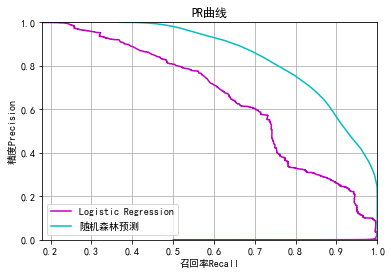

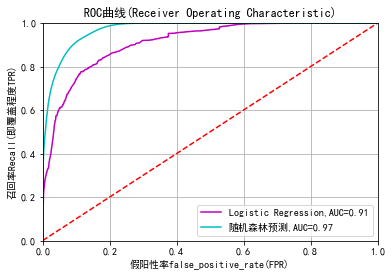

In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
#sklearn中相关库
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,precision_recall_curve,average_precision_score

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#读取数据
train_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv") #训练数据集
test_dataset = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\test.csv") #测试数据集
#submit_dataset = pd.read_csv("submit_data.csv") #提交的数据

#原始数据的处理
train_dataset = train_dataset.drop(['CaseId','Evaluation'],axis=1) #去掉CaseId和Evaluation,得到Qk
test_dataset = test_dataset.drop(['CaseId'],axis=1)
evaluation_true = pd.read_csv("E:\\pyhomework\\machinelearning_homework\\report_01_accident_claims\\data\\train.csv",usecols=['Evaluation']) #读取evaluation,后续可以转换为列表

#Logistic Regression预测
lr = LogisticRegression()
lr.fit(train_dataset, evaluation_true)

pred_train_l = lr.predict(train_dataset) #训练数据的预测结果
pred_test_l = lr.predict(test_dataset) #测试数据的预测结果
pred_test_probability_l = lr.predict_proba(test_dataset)[:,1] #测试数据的预测结果为1的概率，即获得赔偿的概率。[:,0]是预测结果为0的概率

#随机森林预测
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(train_dataset, evaluation_true)

pred_train_r = clf.predict(train_dataset) #训练数据的预测结果
pred_test_r = clf.predict(test_dataset) #测试数据的预测结果
pred_test_probability_r = clf.predict_proba(test_dataset)[:,1] #测试数据的预测结果为1的概率，即获得赔偿的概率。[:,0]是预测结果为0的概率

#绘制PR曲线
y_pro_l = lr.predict_proba(train_dataset)[:,1]
y_pro_r = clf.predict_proba(train_dataset)[:,1]
precision_l, recall_l, thresholds_l = precision_recall_curve(evaluation_true,y_pro_l)
precision_r, recall_r, thresholds_r = precision_recall_curve(evaluation_true,y_pro_r)
plt.figure()
plt.plot(precision_l, recall_l,'m',label='Logistic Regression')
plt.plot(precision_r, recall_r,'c',label='随机森林预测')
plt.legend(loc='lower left')
plt.xlabel('召回率Recall')
plt.ylabel('精度Precision')
plt.grid(True)
plt.xlim([0.18, 1.0])
plt.ylim([0.0, 1.0])
plt.title('PR曲线')
plt.show()

#绘制ROC曲线
false_positive_rate_l, recall_l, thresholds_l = roc_curve(evaluation_true,y_pro_l)
false_positive_rate_r, recall_r, thresholds_r = roc_curve(evaluation_true,y_pro_r)
roc_auc_l = auc(false_positive_rate_l, recall_l)
roc_auc_r = auc(false_positive_rate_r, recall_r)
plt.figure()
plt.title("ROC曲线(Receiver Operating Characteristic)")#verticalalignment='center'→一个规定title格式的参数，个人觉得加上不好看
plt.plot(false_positive_rate_l,recall_l,'m',label='Logistic Regression,AUC=%0.2f'%roc_auc_l)
plt.plot(false_positive_rate_r,recall_r,'c',label='随机森林预测,AUC=%0.2f'%roc_auc_r)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.grid(True)
plt.ylabel('召回率Recall(即覆盖程度TPR)')
plt.xlabel('假阳性率false_positive_rate(FPR)')
plt.show()

可见，随机森林模型的两条曲线均比Logistic Regression更理想。  
综上分析，模型的预测效果为：**随机森林** > **Logistic Regression** > **K-Means**  

将预测结果提交到竞赛网站，得到的成绩依次为：

|方法|成绩|
|:----:|:----:|
|Logistic Regression|/|
|RandomForest|0.850898|

【注】将逻辑回归预测结果提交后，一直没有得到成绩，每次刷新都显示提交的随机森林预测结果的成绩。

## 三、总结
——在建立模型求解的过程中遇到的相关问题及思考
1. lr.predict()和lr.predict_proba()处理后得到的数据类型为<class 'numpy.ndarray'>，为了方便将数据写入csv文件中，我想将案例编号和预测结果、预测为1的概率组合之后一并写入csv文件中，此时需要使用pd.concat()。但是，pd.concat()可以处理的类型为<class 'pandas.core.frame.DataFrame'>，而无法处理ndarray。因此，需要把ndarray转化为DataFrame，此时需要使用pd.DataFrame()。

2. precision, recall, thresholds = precision_recall_curve(evaluation_true,y_pro)  
   这个语句中的thresholds没有使用到，但是precision_recall_curve()返回三个值，因此不能删去，否则会出现错误。但是在使用VScode编写代码时，该处下方一直由橙黄色的曲线标记（如下图），原因不明。
   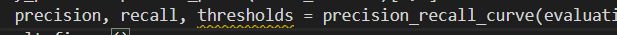
   
3. 将结果提交到竞赛网站。第一次提交没有注意到格式要求，因此第一次得到的成绩为0。后面更改提交文件的表头后重新提交，则有成绩。
 
 
* 写下一点心情：我花了一天写完report01，颇有成就感。不够写完回过头看，发现内容都很简单，使用sklearn中现成的函数处理数据实在是太方便了，要是熟练了应该不需要这么久的时间完成这个报告。发现了notebook是个debug的好工具，写了很多代码之后，在notebook里运，notebook指出bug的方式比VScode容易看。